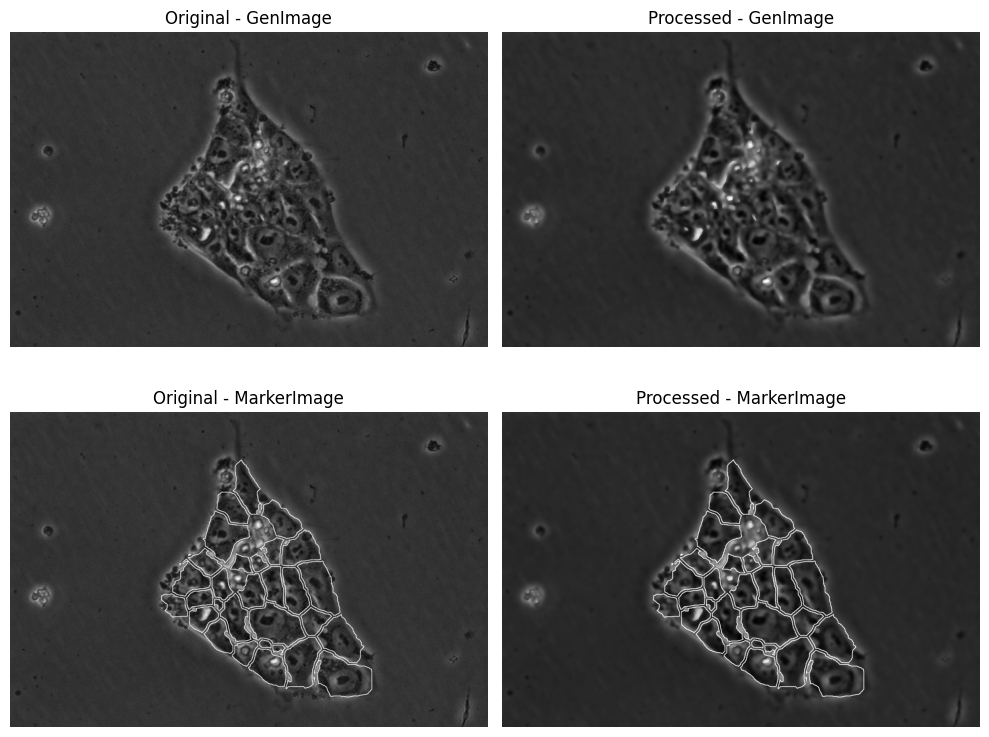

In [5]:
# -*- coding: utf-8 -*-

import numpy as np
import cv2
import matplotlib.pyplot as plt
from numba import jit, prange

def compute_gradients(image):
    """Computes image gradients manually in four directions: North, South, East, and West."""
    grad_north = np.zeros_like(image, dtype=np.float64)
    grad_south = np.zeros_like(image, dtype=np.float64)
    grad_east = np.zeros_like(image, dtype=np.float64)
    grad_west = np.zeros_like(image, dtype=np.float64)

    # Compute gradients using simple differences
    grad_north[:-1, :] = image[1:, :] - image[:-1, :]
    grad_south[1:, :] = image[:-1, :] - image[1:, :]
    grad_east[:, :-1] = image[:, 1:] - image[:, :-1]
    grad_west[:, 1:] = image[:, :-1] - image[:, 1:]

    return grad_north, grad_south, grad_east, grad_west

def perona_malik_conduction(gradients, kappa, method='quadratic'):
    """Computes conduction coefficients based on gradient magnitudes to control diffusion strength."""
    if method == 'quadratic':
        return [np.exp(- (g / kappa) ** 2) for g in gradients]  # Exponential form (Perona-Malik 1990)
    elif method == 'exponential':
        return [1 / (1 + (g / kappa) ** 2) for g in gradients]  # Reciprocal form (alternative approach)
    else:
        raise ValueError("Invalid conduction method. Use 'quadratic' or 'exponential'.")

@jit(nopython=True, parallel=True)
def update_image(image, gradients, conduction_coeffs, delta_t):
    """Optimized update step for anisotropic diffusion using Numba for speedup."""
    diffusion = np.zeros_like(image, dtype=np.float64)

    # Iterate over the image (excluding borders to prevent artifacts)
    for i in prange(1, image.shape[0] - 1):
        for j in prange(1, image.shape[1] - 1):
            # Compute diffusion sum from all directions
            diffusion[i, j] = (
                conduction_coeffs[0][i, j] * gradients[0][i, j] +  # North
                conduction_coeffs[1][i, j] * gradients[1][i, j] +  # South
                conduction_coeffs[2][i, j] * gradients[2][i, j] +  # East
                conduction_coeffs[3][i, j] * gradients[3][i, j]    # West
            )

    # Update the image and clip values to ensure valid intensity range (0-255)
    return np.clip(image + delta_t * diffusion, 0, 255)

def perona_malik_diffusion(image, iterations, delta_t, kappa, method='quadratic'):
    """Applies Perona-Malik anisotropic diffusion to an image over multiple iterations."""
    image = image.astype(np.float64)  # Convert image to float for precise calculations

    for _ in range(iterations):
        gradients = compute_gradients(image)  # Compute directional gradients
        conduction_coeffs = perona_malik_conduction(gradients, kappa, method)  # Compute conduction values
        image = update_image(image, gradients, conduction_coeffs, delta_t)  # Apply diffusion step

    return image.astype(np.uint8)  # Convert back to uint8 for image display

def apply_perona_malik(image_path, iterations=20, delta_t=0.1, kappa=20, method='quadratic'):
    """Loads an image, applies Perona-Malik diffusion, and returns the original and processed image."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load grayscale image

    if image is None:
        print(f"Error: Could not read {image_path}. Check if the file exists.")
        return None

    processed = perona_malik_diffusion(image, iterations, delta_t, kappa, method)  # Apply diffusion
    return image, processed  # Return both original and filtered images

def main():
    """Main function to load, process, and visualize images."""
    image_paths = ["genimage.tif", "markerimage.tif"]  # List of input images
    titles = [
        "Original - GenImage", "Processed - GenImage",
        "Original - MarkerImage", "Processed - MarkerImage"
    ]

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # Create a 2x2 grid of subplots
    axes = axes.flatten()  # Flatten for easier iteration

    for i, image_path in enumerate(image_paths):
        original, processed = apply_perona_malik(image_path, iterations=50, delta_t=0.1, kappa=20, method='quadratic')

        if original is not None and processed is not None:
            axes[2*i].imshow(original, cmap='gray')  # Show original image
            axes[2*i].set_title(titles[2*i])
            axes[2*i].axis("off")

            axes[2*i+1].imshow(processed, cmap='gray')  # Show processed image
            axes[2*i+1].set_title(titles[2*i+1])
            axes[2*i+1].axis("off")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
